In [3]:
import numpy as np
import numba
from numba import prange
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook'])


from plot_functions import plot_connections, plot_poblacion
from main_functions import generate_vecinos_int

# Primera aproximacion. Red cuadrada 2D.

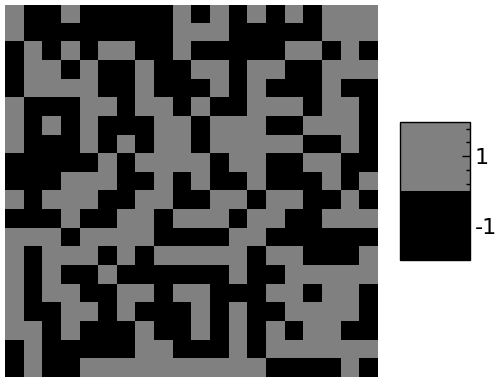

In [76]:
N = 20
# vecinos:
nu = 4
lattice = np.random.random((N, N))
lattice[lattice >= .5] = 1
lattice[lattice < .5] = -1

fig, ax = plt.subplots(figsize=(6, 6))
plot_poblacion(lattice, ax)

## Algoritmo de metropolis

In [71]:
@numba.njit(nogil=True)
def metropolis(lattice, steps, T):
    lattice = lattice.copy()
    N = len(lattice)
    spins_sum = np.empty(steps)

    for step in range(steps):
        x = np.random.randint(0, N) # x in [0, 1, 2, ..., N-1]
        y = np.random.randint(0, N)
        
        spin_i = lattice[x, y]
        spin_f = -1*spin_i
        
        # calculo de la opinion de los 4 vecinos
        S = 0
        # vecinos de x
        if x==0:
            S += lattice[x+1, y]
            S += lattice[N-1, y] 
        elif x==N-1:
            S += lattice[0, y]
            S += lattice[x-1, y] 
        else:
            S += lattice[x+1, y]
            S += lattice[x-1, y] 
            
        # vecinos de y
        if y==0:
            S += lattice[x, y+1]
            S += lattice[x, N-1] 
        elif y==N-1:
            S += lattice[x, 0]
            S += lattice[x, y-1] 
        else:
            S += lattice[x, y+1]
            S += lattice[x, y-1] 
        
        
        # ver si se acepta el cambio
        if (S * spin_f > 0) or (np.random.random() < np.exp(-abs(S*spin_f)/T)):
            # condicion 1: el cambio esta a favor de la opinión de los vecinos -> S*spin_f > 0
            # condicion 2: el cambio no esta a favor pero por prob se acepta -> S*spin_f < 0 
            # ponemos el valor absoluto para mantener el sentido del modelo de ising
            lattice[x, y] = spin_f
        
        spins_sum[step] = np.sum(lattice) 
        
    return lattice, spins_sum

### Ejemplo

In [79]:
%%time
montecarlo_steps = 500000
T = 0.5
lattice_final, spins_sum = metropolis(lattice, montecarlo_steps, T)

CPU times: total: 188 ms
Wall time: 223 ms


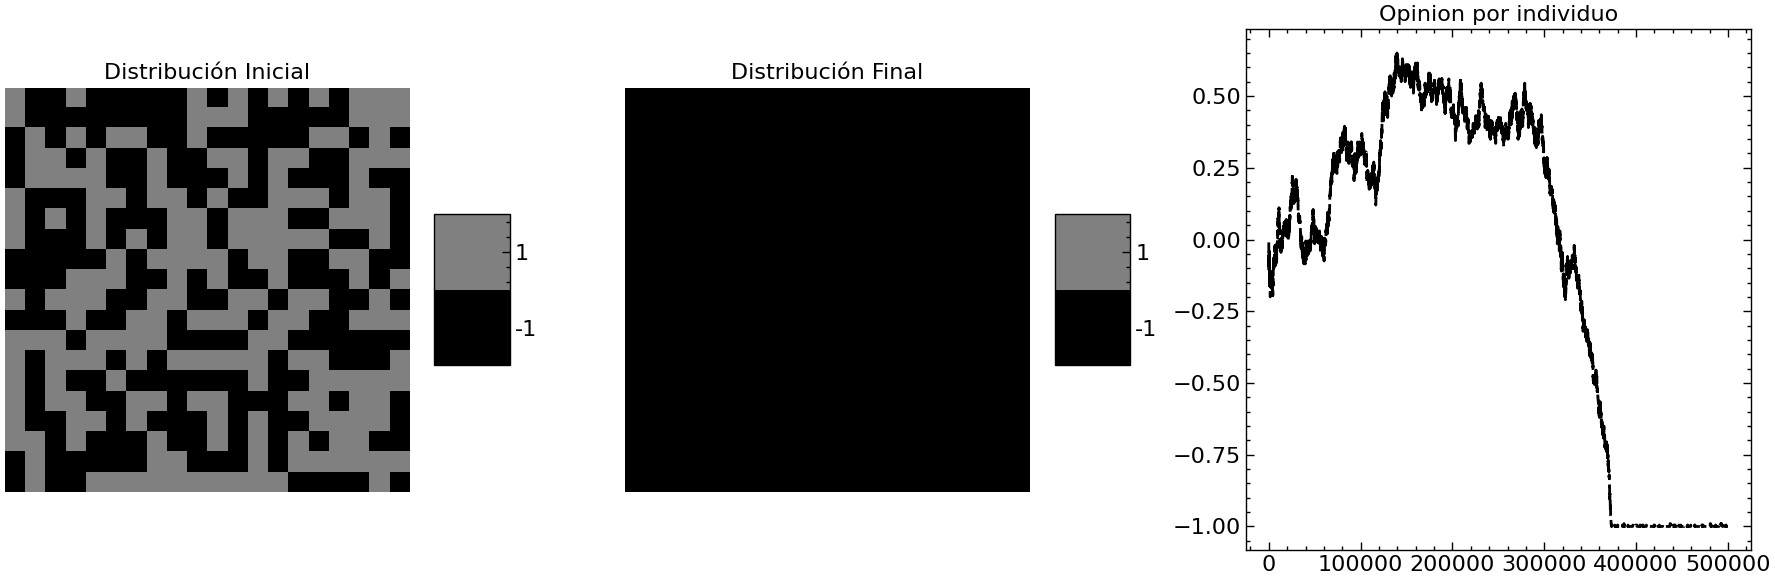

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

plot_poblacion(lattice, ax1)
ax1.set_title('Distribución Inicial')

plot_poblacion(lattice_final, ax2)
ax2.set_title('Distribución Final')

ax3.plot(spins_sum/N**2, 'k--')
ax3.set_title('Opinion por individuo')
plt.tight_layout()
plt.show()

### Pasos necesarios para alcanzar el equilibrio

In [85]:
@numba.njit(nogil=True)
def init_poblacion(N, prob):
    """ genera una poblacion en la que un porcentaje prob
        esta en contra y (1-prob) a favor 
        
        NO HE IMPLEMENTADO INDEX SLICING PORQUE NUMBA NO LO PERMIT
    """
    pob = np.random.random((N, N))
    pob_int = np.ones((N, N))
    pob_int = pob_int * -(pob < prob) + (pob >= prob)
    return pob_int

In [86]:
@numba.njit(nogil=True)
def find_step(m_arr):
    """ funcion que encuentra el indice para el cual 
        se puede considerer que m se ha estabilizado 
        de acuerdo al parametro de tolerancia epsilon
    """
    step = 0
    epsilon = 0.0001
    for m in m_arr[1000:]:
        if abs(1 - abs(m)) < epsilon:
            return step
        step += 1

In [83]:
%%time
T = 0.5
montecarlo_steps = 5000000
N_arr = np.arange(10, 60+10, 10)
step_f = np.empty(len(N_arr))

for i, N in enumerate(N_arr):
    lattice = init_poblacion(N, 0.75)
    _, spins_sum = metropolis(lattice, montecarlo_steps, T)
    step_f[i] = find_step(spins_sum/N**2)

CPU times: total: 1min 20s
Wall time: 1min 33s


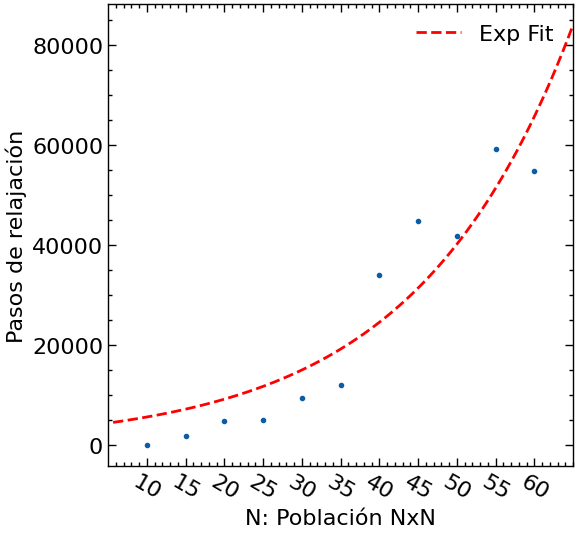

In [84]:
fig, ax = plt.subplots(figsize=(6, 6))


def exp_func(x, a, b, c):
    return a*np.exp(-c*(x-b))

x = N_arr
y = step_f

(a, b, c), _ = curve_fit(exp_func, x, y, [50, 50, 0.001])

x = np.linspace(0, 65, 100)
ax.plot(x, exp_func(x, a, b, c), 'r--', label='Exp Fit')

ax.plot(N_arr, step_f, '.')

ax.set_ylabel('Pasos de relajación')
ax.set_xticks(N_arr)
plt.xticks(rotation=-30)
ax.set_xlabel('N: Población NxN')
ax.set_xlim([5, 65])
plt.legend()
plt.show()

Usaremos esta aproximación de los pasos relajacion para acelerar los cálculos usando un paso de montecarlo adecuado para cada N y no uno demasiado grande.
## Estudio de la temperatura critica 

In [216]:
@numba.njit(parallel=True, nogil=True)
def magnetizacion_T(N, prob, T_arr, steps):
    pob_n = init_poblacion(N, prob)
    pob_p = - pob_n.copy()

    # prealocar m
    m_n = np.empty(len(T_arr))
    m_p = np.empty(len(T_arr))

    for i in prange(len(T_arr)):
        T = T_arr[i]
        _, spins = metropolis(pob_n, steps, T)
        m_n[i] = np.mean(spins[-10000:]/N**2)
        _, spins = metropolis(pob_p, steps, T)
        m_p[i] = np.mean(spins[-10000:]/N**2)
    return m_n, m_p

In [217]:
%%time
N = 20
# pasos de montecarlo
steps = 2000000
# array de temperaturas
T_arr = np.linspace(0.01, 10)

m_n, m_p = magnetizacion_T(N, 0.75, T_arr, steps)

CPU times: total: 1min 47s
Wall time: 17.9 s


C:\Users\Maxi\anaconda3\envs\numba\lib\site-packages\matplotlib\ticker.py:2937: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
C:\Users\Maxi\anaconda3\envs\numba\lib\site-packages\matplotlib\ticker.py:2937: RuntimeWarning: invalid value encountered in double_scalars
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


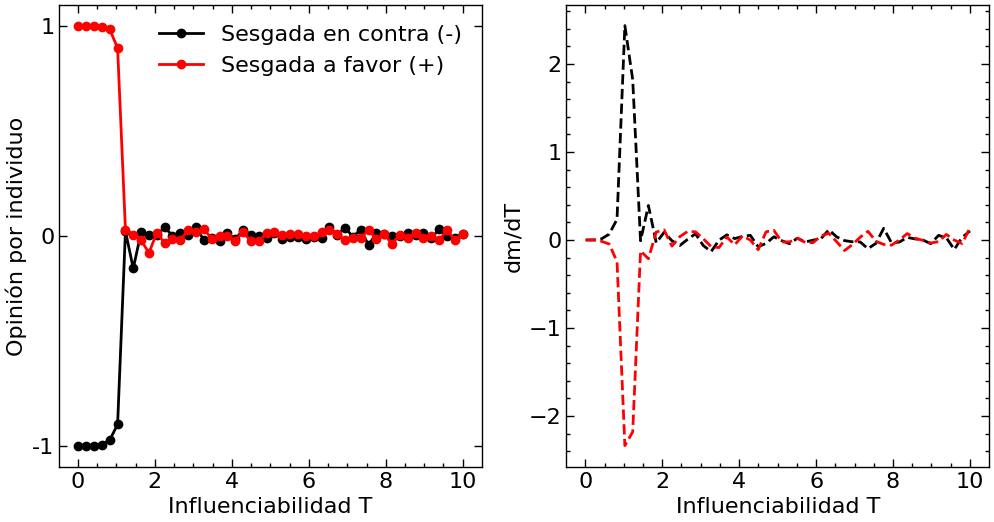

In [218]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(T_arr, m_n, 'k-o', label='Sesgada en contra (-)')
ax1.plot(T_arr, m_p, 'r-o', label='Sesgada a favor (+)')
ax1.set_xlabel('Influenciabilidad T')
ax1.set_ylabel('Opinión por individuo')
ax1.set_yticks([1, 0, -1], labels=['1', '0', '-1'])
ax1.legend()

ax2.plot(T_arr, np.gradient(m_n, T_arr), 'k--')
ax2.plot(T_arr, np.gradient(m_p, T_arr), 'r--')
ax2.set_xlabel('Influenciabilidad T')
ax2.set_ylabel('dm/dT')

plt.show()

Definimos la temperatura crítica como la temperatura para la cual hay un cambio de pendiente pasando de 0 a infinito (obviamente no va a ser infinito) i.e. $T_c = T \text{such} \max\{dm/dT\}$

En estas simulaciones se esta utilizando la librería de optimización numba por lo que no podemos simplemente usar np.gradient por ello se usará la derivada numérica "Diferencias centrales" como se muestra abajo la precisión es más que suficiente para un analisis cualitativo.

In [114]:
dT = T_arr[1]-T_arr[0]
dmdT_cent = (m_p[2:] - m_p[:-2]) / (2*dT)
dmdT = np.gradient(m_p, T_arr)
print(f'np.gradient               Tc(p) = {T_arr[dmdT==np.max(dmdT)][0]:.10f}')
print(f'Diferencias centrales:    Tc(p) = {T_arr[1:-1][dmdT_cent==np.max(dmdT_cent)][0]:.10f}')

dmdT_cent = (m_n[2:] - m_n[:-2]) / (2*dT)
dmdT = np.gradient(m_n, T_arr)
print(f'np.gradient               Tc(n) = {T_arr[dmdT==np.max(dmdT)][0]:.10f}')
print(f'Diferencias centrales:    Tc(n) = {T_arr[1:-1][dmdT_cent==np.max(dmdT_cent)][0]:.10f}')

np.gradient               Tc(p) = 1.8448979592
Diferencias centrales:    Tc(p) = 1.8448979592
np.gradient               Tc(n) = 1.0293877551
Diferencias centrales:    Tc(n) = 1.0293877551


In [115]:
@numba.njit(nogil=True)
def temperatura_critica(T_arr, m_p, m_n):
    # diferencias centrales
    dT = T_arr[1]-T_arr[0]
    dmdT_n = (m_n[2:] - m_n[:-2]) / (2*dT)
    dmdT_p = (m_p[2:] - m_p[:-2]) / (2*dT)
    
    # promedio de ambos valores
    Tc_n = T_arr[1:-1][dmdT_n==np.max(dmdT_n)][0]
    Tc_p = T_arr[1:-1][dmdT_p==np.max(dmdT_p)][0]
    Tc = 0.5*(Tc_n + Tc_p)
    return Tc

In [120]:
print(f'Calculo final Tc = {temperatura_critica(T_arr, m_p, m_n):.2f}')

Calculo final Tc = 1.44


### Dependencia con N

In [101]:
%%time
@numba.njit(parallel=True, nogil=True)
def numba_op(N_arr, steps):

    # array de temperaturas
    T_arr = np.linspace(0.01, 6)
    # prealocamos la Tc
    Tc = np.empty(len(N_arr))

    for i in prange(len(N_arr)):
        N = N_arr[i]
        m_n, m_p = magnetizacion_T(N, 0.75, T_arr, steps[i])
        Tc[i] = temperatura_critica(T_arr, m_p, m_n)
        print(f'N: {N} Done')
    return Tc
N_arr = np.arange(10, 50+10, 10)
# tomo dos ordenes de magnitud más por paso para asegurar 
# que la temperatura critica se calcula usando los valores
# de m YA RELAJADOS
steps = 100 * exp_func(N_arr, a, b, c)
Tc = numba_op(N_arr, steps.astype(int))

N: 10 Done
N: 20 Done
N: 30 Done
N: 40 Done
N: 50 Done
CPU times: total: 40min 39s
Wall time: 6min 24s


In [105]:
print(steps.astype(int))

[ 560553  917056 1500289 2454448 4015437]


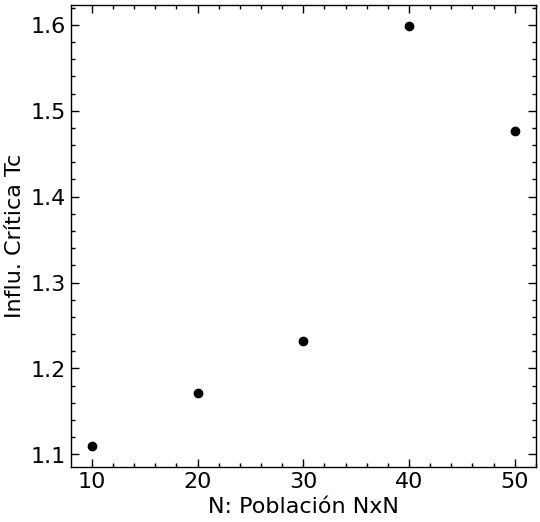

In [103]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(N_arr, Tc, 'ko')
ax.set_xlabel('N: Población NxN')
ax.set_ylabel('Influ. Crítica Tc')
plt.show()

## Estudio de la correlacion.

In [219]:
@numba.njit(nogil=True)
def metropolis_correlation(lattice, steps, T):
    """se requiere N IMPAR"""
    lattice = lattice.copy()
    N = len(lattice)
    spins_sum = np.empty(steps)
    x0, y0 = int((N-1)/2), int((N-1)/2)
    DJK = np.empty((steps, x0))
       
    for step in range(steps):
        x = np.random.randint(0, N) # x in [0, 1, 2, ..., N-1]
        y = np.random.randint(0, N)
        
        spin_i = lattice[x, y]
        spin_f = -1*spin_i
        
        # calculo de la opinion de los 4 vecinos
        S = 0
        # vecinos de x
        if x==0:
            S += lattice[x+1, y]
            S += lattice[N-1, y] 
        elif x==N-1:
            S += lattice[0, y]
            S += lattice[x-1, y] 
        else:
            S += lattice[x+1, y]
            S += lattice[x-1, y] 
            
        # vecinos de y
        if y==0:
            S += lattice[x, y+1]
            S += lattice[x, N-1] 
        elif y==N-1:
            S += lattice[x, 0]
            S += lattice[x, y-1] 
        else:
            S += lattice[x, y+1]
            S += lattice[x, y-1] 
        
        
        # ver si se acepta el cambio
        if (S * spin_f > 0) or (np.random.random() < np.exp(-abs(S*spin_f)/T)):
            # condicion 1: el cambio esta a favor de la opinión de los vecinos -> S*spin_f > 0
            # condicion 2: el cambio no esta a favor pero por prob se acepta -> S*spin_f < 0 
            # ponemos el valor absoluto para mantener el sentido del modelo de ising
            lattice[x, y] = spin_f
        
        spins_sum[step] = np.sum(lattice) 
            
        for i in range(1, x0+1):
            # correlacion
            aux = 0
            aux += lattice[x0-i, y0]*lattice[x0, y0]
            aux += lattice[x0+i, y0]*lattice[x0, y0]
            aux += lattice[x0, y0-i]*lattice[x0, y0]
            aux += lattice[x0, y0+i]*lattice[x0, y0]
            
            DJK[step, i-1] = aux/4
        
        
        
    
              
    return DJK, spins_sum


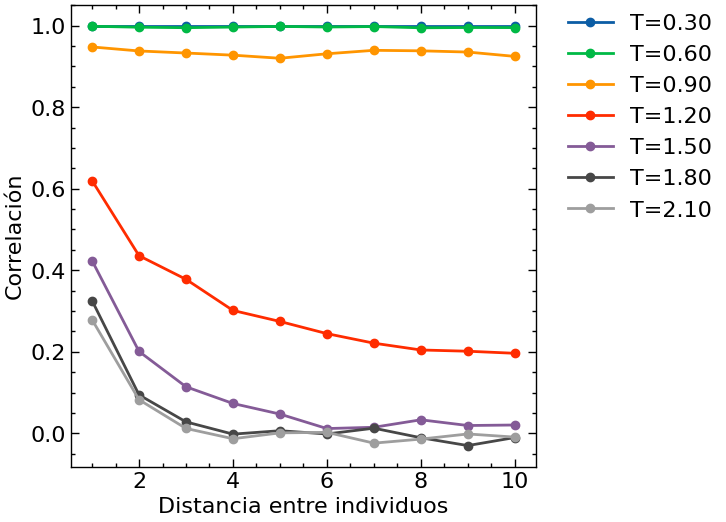

CPU times: total: 8.53 s
Wall time: 9.23 s


In [181]:
%%time
N = 21
# pasos de montecarlo
steps = 2000000
pob = init_poblacion(N, 0.75)
# array de temperaturas
# T_arr = np.linspace(0.01, 4, 8)
T_arr = np.arange(2, 15, 2) * 0.15
N_arr = np.arange(1, int((N-1)/2)+1)
fig, ax = plt.subplots(figsize=(6, 6))

for i, T in enumerate(T_arr):
    DJK, _ = metropolis_correlation(pob, steps, T)
    djk = np.mean(DJK[-500000:, :], axis=0)
    ax.plot(N_arr, djk, 'o-', label=f'T={T:.2f}')


ax.set_ylabel('Correlación')
ax.set_xlabel('Distancia entre individuos')
plt.legend(bbox_to_anchor=(1.05, 1), 
           loc='upper left', borderaxespad=0.)
plt.show()

### Exponente critico

In [234]:
%%time
N = 20
# pasos de montecarlo
steps = 2000000


T_arr = np.linspace(0.01, 10)  
N_arr = np.arange(1, int((N-1)/2)+1)

eps_arr = np.empty(len(T_arr))


def eps_func(x, eps):
    a=1 # añadir luego lo he quitado
    return a*np.exp(-x/eps)


m = np.empty(len(T_arr))

for i, T in enumerate(T_arr):
    # poblacion positiva
    pob = -init_poblacion(N, 0.75)
    DJK, spins_sum= metropolis_correlation(pob, steps, T)
    m[i] = np.mean(spins_sum[-10000:])/N**2
    djk = np.mean(DJK[-10000:, :], axis=0)
    # print(djk)
    eps, _ = curve_fit(eps_func, N_arr, djk, [1], maxfev=5000)
    
    eps_arr[i] = eps

CPU times: total: 48.4 s
Wall time: 49.6 s


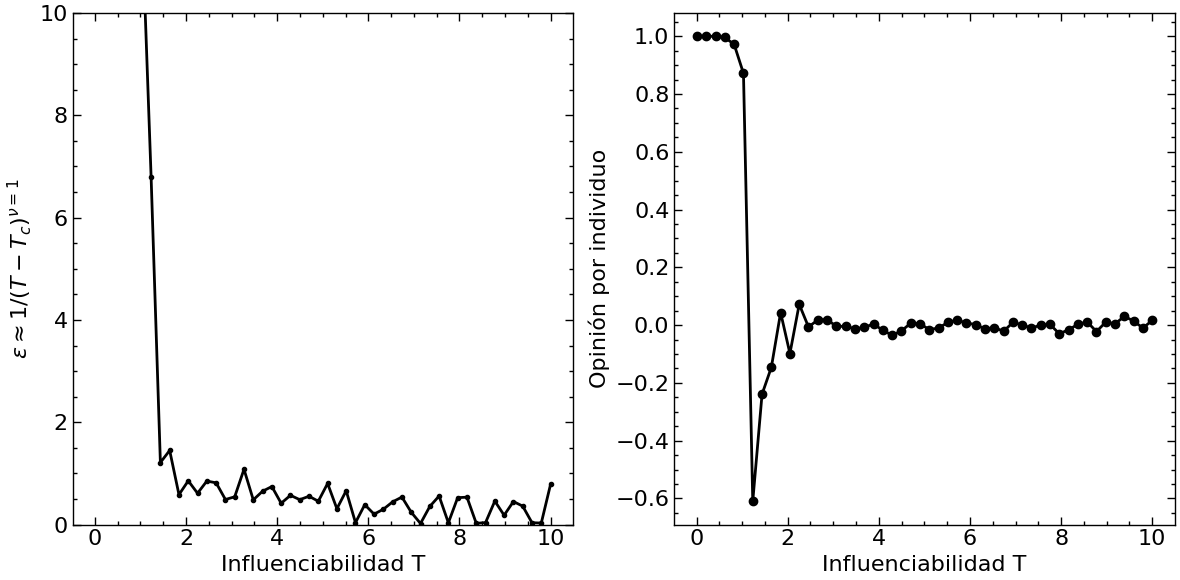

In [236]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(T_arr, eps_arr, 'k.-')
# ax1.set_yscale('log')
ax1.set_ylim([0, 10])
ax1.set_ylabel(r'$\epsilon \approx 1/(T-T_c)^{\nu=1}$')
ax1.set_xlabel('Influenciabilidad T')

ax2.plot(T_arr, m, 'ko-')
ax2.set_xlabel('Influenciabilidad T')
ax2.set_ylabel('Opinión por individuo')

plt.tight_layout()
plt.show()

para hacer un calculo mas preciso habria que calcular la correlacion teniendo en cuenta el temrino s0si ya que para T<Tc no se puede aproximar este valor como cero, la aproximacion que hemos hehco es valica para T>Tc pero es mas que suficiente 

https://physics.stackexchange.com/questions/59678/what-is-the-definition-of-correlation-length-for-the-ising-model